In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Read the collected data
df = pd.read_csv('Cardata_BIG.csv')

#Lets change names to english
df.columns = ['Index','Car type', 'Price', 'Id', 'Yearly Check', 'Limited benefit','Model', 'Mileage','Engine','Seller','Owner amount','Updated','License plate number', 'Location','Delivery Cost','Transmission','Manufacturer','Full Benefit','Drivetrain','Year']
#Lets drop some unnecessary columns
df=df.drop(columns=['Index', 'Id', 'Yearly Check','Owner amount','Updated','License plate number','Delivery Cost','Limited benefit','Full Benefit'])
#Lets drop the rows with NULL values
df = df.dropna(how='any',axis=0) 

df.head()

#Lets clean data, where Engine is Electric or only Bensiini or Diesel, without Engine Size information. 
#And lets give average engine size to them so we can still have them with us, but engine size wont distort the results.
df.Engine[df.Engine == 'Sähkö'] = '20 , Sähkö'
df.Engine[df.Engine == 'Diesel'] = '20 , Diesel'
df.Engine[df.Engine == 'Bensiini'] = '20 , Bensiini'

#Lets change Saab models back to text, because excel changes them to dates.
df.Model[df.Model == '09-May'] = '9-5'
df.Model[df.Model == '09-Mar'] = '9-3'

#Lets separate Engine type and size to different columns.
new = df["Engine"].str.split(",", n = 1, expand = True) 
df["Engine Size"]= new[0] 
df['Engine Size'] = df['Engine Size'].map(lambda x: str(x)[:-2])
df["Fuel type"]= new[1]   
df.drop(columns =["Engine"], inplace = True) 
df['Engine Size']=df['Engine Size'].astype('float')

#Lets create area from Location and frop City information
new = df["Location"].str.split(",", n = 1, expand = True) 
df["Area"]= new[1]
df.drop(columns =["Location"], inplace = True) 

#Lets drop cars that location is outside Finland, because the price may vary because of different tax policy
df = df[~df.Area.str.endswith("Suomen ulkopuolella")]

#Change all different company names to just Company
def change_names(x):
    if x == 'Private seller':
        return 'Private seller'
    else:
        return 'Company'
df['Seller'] = df['Seller'].apply(change_names)

#Lets see if there is null and drop those rows
df = df[pd.notnull(df['Fuel type'])]
total = df.isnull().sum().sort_values(ascending=False)

#Lets define the target attribute
target = 'Price'

#Lets change Price and Mileage from float to int
df['Price']=df['Price'].astype('int')
df['Mileage']=df['Mileage'].astype('int')

#df.head(10)
#df.describe()
df.dtypes

Car type         object
Price             int32
Model            object
Mileage           int32
Seller           object
Transmission     object
Manufacturer     object
Drivetrain       object
Year              int64
Engine Size     float64
Fuel type        object
Area             object
dtype: object

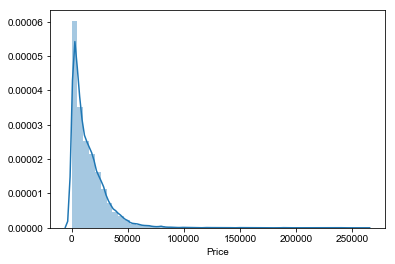

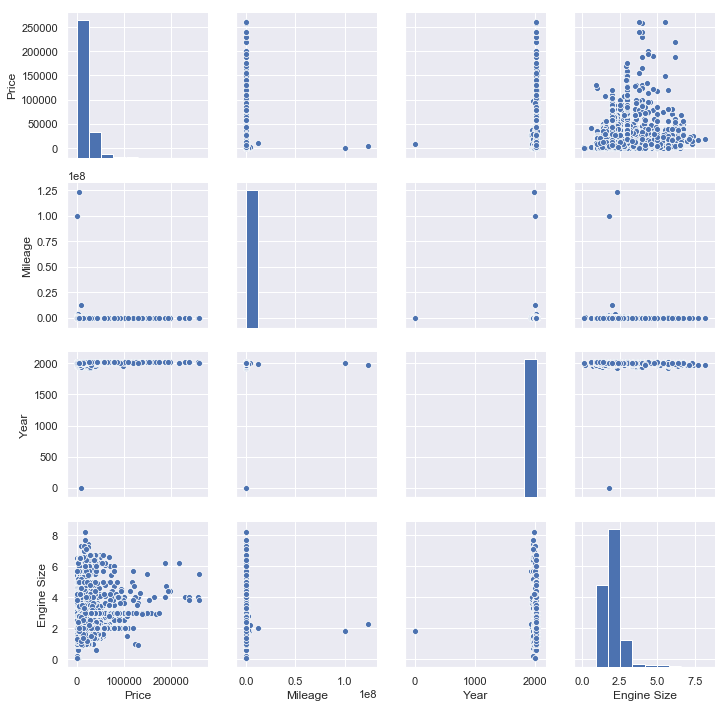

<Figure size 2880x2880 with 0 Axes>

<Figure size 2880x2880 with 0 Axes>

In [2]:
df['Price'].describe()

#histogram
sns.distplot(df['Price']);

#Scatterplot
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

plt.figure(figsize=(40,40)) 


We can see that these plots don't describe data too good, because there is lots of outlier data. So in the next step we will remove these outliers. 

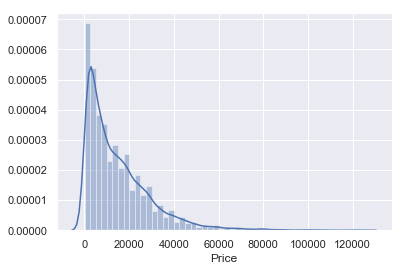

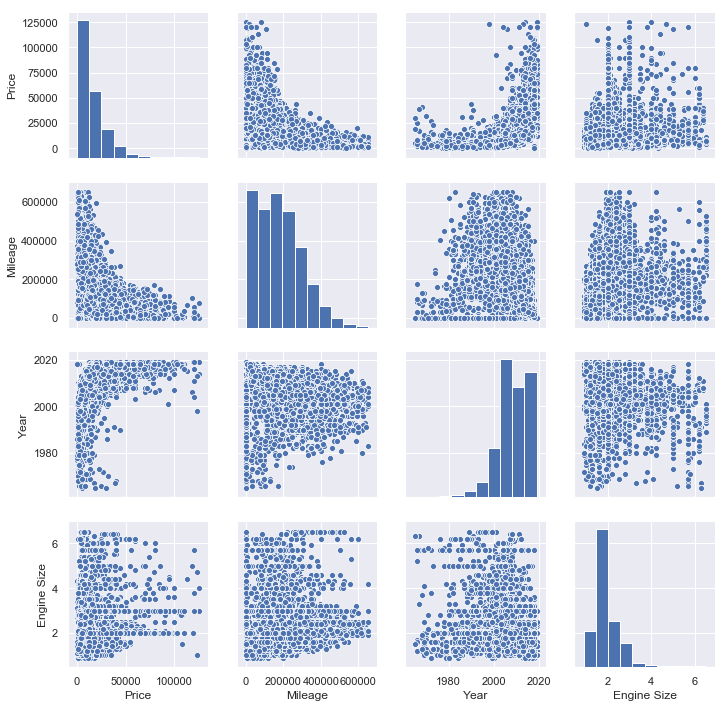

,Price,Mileage,Year,Engine Size
count,20422.000000,20422.000000,20422.000000,20422.000000
mean,14962.471159,176139.961414,2008.517334,2.038380
std,14607.125866,121605.718718,7.140154,0.692581
min,100.000000,0.000000,1965.000000,0.900000
25%,3990.000000,82000.000000,2004.000000,1.600000
50%,10800.000000,168000.000000,2009.000000,2.000000
75%,21500.000000,254000.000000,2014.000000,2.200000
max,124900.000000,650000.000000,2019.000000,6.500000


In [3]:
#Lets drop all cars that have mileage of 650 000 km or more
df = df[~(df[['Mileage']] > 650000).all(axis=1)]

#Lets drop all cars that year model is older than 1965
df = df[~(df[['Year']] < 1965).all(axis=1)]

#Lets drop all cars that price is over 125000 € or under 100 €
df = df[~(df[['Price']] > 125000).all(axis=1)]
df = df[~(df[['Price']] < 100).all(axis=1)]

#Lets drop all cars that engine size is over 6.5 or under 0.9 Litres
df = df[~(df[['Engine Size']] > 6.5).all(axis=1)]
df = df[~(df[['Engine Size']] < 0.9).all(axis=1)]

#sns.distplot(np.log(df['Price']));
sns.distplot(df['Price']);

#Scatterplot
sns.set()
sns.pairplot(df, size = 2.5)
plt.show();

df.describe()

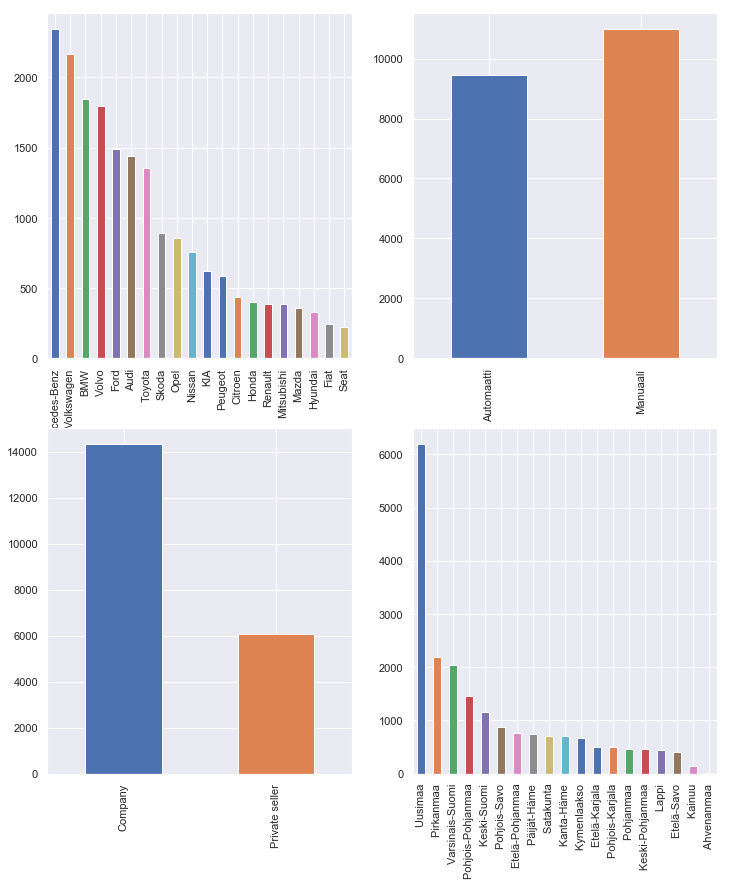

In [4]:
#Lets see how many numerical and categorical features is there
numerical_feats = df.dtypes[df.dtypes != "object"].index
categorical_feats = df.dtypes[df.dtypes == "object"].index

fig, axarr = plt.subplots(2, 2, figsize=(12, 14))

df['Manufacturer'].value_counts().head(20).plot.bar(
    ax=axarr[0][0])

df['Seller'].value_counts().sort_index().plot.bar(
    ax=axarr[1][0])

df['Transmission'].value_counts().sort_index().plot.bar(
    ax=axarr[0][1])

df['Area'].value_counts().head(20).plot.bar(
    ax=axarr[1][1])

Price          1.000000
Year           0.643567
Engine Size    0.140964
Mileage       -0.587333
Name: Price, dtype: float64


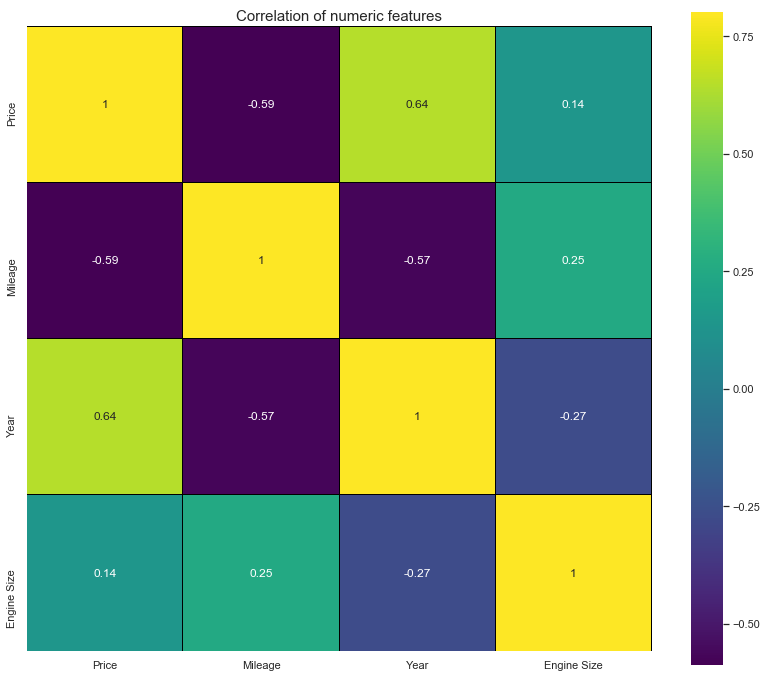

In [5]:
correlation = df.select_dtypes(include=[np.number]).corr()

# Zoomed HeatMap of the most Correlayed variables
zoomedCorrelation = correlation.loc[['Price','Mileage','Year','Engine Size'], ['Price','Mileage','Year','Engine Size']]
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of numeric features',size=15)
sns.heatmap(zoomedCorrelation, square = True, linewidths=0.01, vmax=0.8, annot=True,cmap='viridis',
            linecolor="black", annot_kws = {'size':12})

print(correlation['Price'].sort_values(ascending = False))

Text(0.5, 1.0, 'Normally distributed')

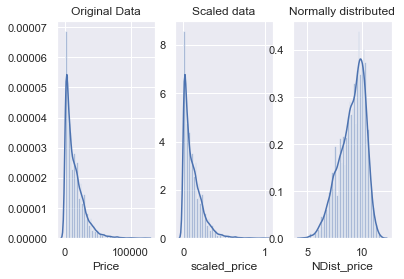

In [6]:
from mlxtend.preprocessing import minmax_scaling

#Changing data to narmally distributed
df["NDist_price"] = np.log1p(df["Price"])
df["NDist_mileage"] = np.log1p(df["Mileage"])
df["NDist_year"] = np.log1p(df["Year"])
df["NDist_engine_size"] = np.log1p(df["Engine Size"])

#Changing data to scaled 
df['scaled_price'] = minmax_scaling(df['Price'], columns = [0])
df['scaled_mileage'] = minmax_scaling(df['Mileage'], columns = [0])
df['scaled_year'] = minmax_scaling(df['Year'], columns = [0])
df['scaled_engine_size'] = minmax_scaling(df['Engine Size'], columns = [0])

#Lets create subplotgrid
fig, ax=plt.subplots(1,3)

#Plotting original data
sns.distplot(df['Price'], ax=ax[0])
ax[0].set_title("Original Data")

#Plotting scaled data
sns.distplot(df['scaled_price'], ax=ax[1])
ax[1].set_title("Scaled data")

#Plotting normalized data
sns.distplot(df['NDist_price'], ax=ax[2])
ax[2].set_title("Normally distributed")


In [7]:
#Defines price as a component what we want to know and then features which we want to use to calculate the price
y = df.Price
#Lets decide features that we want to use
features = ['Model','Seller','Mileage','Transmission','Manufacturer','Drivetrain','Year','Engine Size','Fuel type']

#Features in normally distributed and scaled forms
n_dist_features = ['Model','Seller','NDist_mileage','Transmission','Manufacturer','Drivetrain','NDist_year','NDist_engine_size','Fuel type']
#y_n_dist = df["NDist_price"]
scaled_features = ['Model','Seller','scaled_mileage','Transmission','Manufacturer','Drivetrain','scaled_year','scaled_engine_size','Fuel type']
#y_st = df["scaled_price"]

X = pd.get_dummies(df[features])
X_st = pd.get_dummies(df[scaled_features])
X_ndist = pd.get_dummies(df[n_dist_features])

#Normal values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Scaled numerical values 
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y, test_size=0.1, random_state=200)
#Normally distributed values
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_ndist, y, test_size=0.1, random_state=12)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor     
from sklearn.neighbors import KNeighborsRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Decision tree regressor
param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
grid_dtree = DecisionTreeRegressor(random_state=1)
grid_dtree.fit(X_train, y_train)
pred_dtree = grid_dtree.predict(X_test)
#print('Decision tree',mean_absolute_error(y_test, pred_dtree))
print('Decision tree normal values accurary:',grid_dtree.score(X_test,y_test))

#XGBRegressor
"""XGBR = XGBRegressor()
XGBR.fit(X_train, y_train, verbose=False)
XGBR_pred = XGBR.predict(X_test)
#print('XGBR',mean_absolute_error(y_test, XGBR_pred))
print('XGBR model accurary:',XGBR.score(X_test,y_test))


#XGBRegressor
XGBRs = XGBRegressor()
XGBRs.fit(X_train_st, y_train_st, verbose=False)
XGBR_pred = XGBRs.predict(X_test_st)
#print('XGBR',mean_absolute_error(y_test_st, XGBR_pred))
print('XGBR scaled model accurary:',XGBRs.score(X_test_st,y_test_st))"""

#Random forest regressor
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
melb_preds = rf.predict(X_test)
#print('Random Forest',mean_absolute_error(y_test, melb_preds))
print('Random forest normal values accurary:',rf.score(X_test,y_test))

#Random forest with scaled data
forest_model_st = RandomForestRegressor(random_state=1)
forest_model_st.fit(X_train_st, y_train_st)
melb_preds_st = forest_model_st.predict(X_test_st)
#print('Random Forest scaled',mean_absolute_error(y_test_st, melb_preds_st))
print('Random forest scaled model accurary:',forest_model_st.score(X_test_st,y_test_st))

#Random forest with normalized data
"""forest_model_n = RandomForestRegressor(random_state=1)
forest_model_n.fit(X_train_n, y_train_st)
melb_preds_n = forest_model_n.predict(X_test_st)
#print('Random Forest',mean_absolute_error(y_test_n, melb_preds_n))
print('Random forest normalized model accurary:',forest_model_n.score(X_test_n,y_test_n))

#KNN
KNN=KNeighborsRegressor()
KNN.fit(X_train_st, y_train_st)
KNN_preds = KNN.predict(X_test_st)
print('KNN accurary:',KNN.score(X_test_st,y_test_st))"""

Decision tree normal values accurary: 0.8558883040690407
Random forest normal values accurary: 0.9115370957097428
Random forest scaled model accurary: 0.9102018559553097


"forest_model_n = RandomForestRegressor(random_state=1)\nforest_model_n.fit(X_train_n, y_train_st)\nmelb_preds_n = forest_model_n.predict(X_test_st)\n#print('Random Forest',mean_absolute_error(y_test_n, melb_preds_n))\nprint('Random forest normalized model accurary:',forest_model_n.score(X_test_n,y_test_n))\n\n#KNN\nKNN=KNeighborsRegressor()\nKNN.fit(X_train_st, y_train_st)\nKNN_preds = KNN.predict(X_test_st)\nprint('KNN accurary:',KNN.score(X_test_st,y_test_st))"

In [11]:
### This will ask you to enter your car details.
manufacturer = input('Manufacturer: ')
model = input('Model: ')   
year = input('Year: ')
mileage = int(input('Mileage tkm: '))
mileage = mileage * 1000

fuel_type = int(input('Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö: '))
if fuel_type == 1:
    fuel_type = "Bensiini"
elif fuel_type == 2:
    fuel_type = "Diesel"
elif fuel_type == 3:
    fuel_type = "Hybridi"
elif fuel_type == 4:
    fuel_type = "Sähkö"
fuel_type = ' ' + fuel_type

#If fuel type is electric it will not ask engine size, because there is none. 
#We will use the mean size, which is 2.0 just like we did in cleaning phase.
if fuel_type == ' ' + 'Sähkö':
    engine_size = 2.0
else:
    engine_size = input('Engine size: ')
    
drivetrain = int(input('Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: '))
if drivetrain == 1:
    drivetrain = "Etuveto"
elif drivetrain == 2:
    drivetrain = "Takaveto"
elif drivetrain == 3:
    drivetrain = "Neliveto"
    
transmission = int(input('Transmission: 1=Manuaali, 2=Automaatti: '))
if transmission == 1:
    transmission = "Manuaali"
elif transmission == 2:
    transmission = "Automaatti"
elif transmission == 3:
    transmission = "Neliveto"

seller = int(input('Private seller or Company: 1=Private seller, 2=Company: '))
if seller == 1:
    seller = "Private seller"
elif seller == 2:
    seller = "Company"
   
"""
Variables for manual testing purposes
year = 1993
mileage = 250
engine_size = 2.0
model = 'Calibra'
seller = 'Private seller'
transmission = 'Manuaali'
manufacturer = 'Opel'
fuel_type = 'Bensiini'
drivetrain = 'Etuveto'
"""
    
#Deletes all the files from dataframe, but leaves columns just like they were
odt=(X_test[:1])
for col in odt.columns:
    odt[col].values[:] = 0
    
#Enter values of the car that price you want to predict.
odtmodel = 'Model_' + model
odtseller = 'Seller_' + seller
odttransimission = 'Transmission_' + transmission
odtmanufacturer = 'Manufacturer_' + manufacturer
odtdrivetrain = 'Drivetrain_' + drivetrain
odtfueltype = 'Fuel type_' + fuel_type
 
odt.loc[:, 'Year'] = year
odt.loc[:, 'Mileage'] = mileage
odt.loc[:, 'Engine Size'] = engine_size
odt.loc[:,  odtmodel] = 1
odt.loc[:,  odtseller] = 1
odt.loc[:,  odttransimission] = 1
odt.loc[:,  odtmanufacturer] = 1
odt.loc[:,  odtdrivetrain] = 1
odt.loc[:,  odtfueltype] = 1

try:
    price = int((rf.predict(odt)))
    print("\n")
    print('Car price is (Without scaling)',price)
except:
    print('Maker/Model unknown to database')
    
#If you want to compare the results of real price and calculated price
x=0
for keys,values in y_test.items():   
    #print(values,melb_preds[x])
    x+=1
    
#Adds data to dataframe
car_test=df
car_test.loc[-1, 'Year'] = year
car_test.loc[-1, 'Mileage'] = mileage
car_test.loc[-1, 'Engine Size'] = engine_size
car_test.loc[-1, 'Model'] = model
car_test.loc[-1, 'Seller'] = seller
car_test.loc[-1, 'Transmission'] = transmission
car_test.loc[-1, 'Manufacturer'] = manufacturer
car_test.loc[-1, 'Fuel type'] = fuel_type
car_test.loc[-1, 'Drivetrain'] = drivetrain

car_test['scaled_mileage'] = minmax_scaling(car_test['Mileage'], columns = [0])
car_test['scaled_year'] = minmax_scaling(car_test['Year'], columns = [0])
car_test['scaled_engine_size'] = minmax_scaling(car_test['Engine Size'], columns = [0])
car_test = pd.get_dummies(car_test[scaled_features])
try:
    car_price=int(forest_model_st.predict(car_test.tail(1)))
    print('Car price is (Scaled values)',car_price)
    avg=(car_price + price)/2
    print('Car pride is (AVG)',avg)
except:
    pass


Manufacturer: Toyota
Model: Avensis
Year: 2016
Mileage tkm: 56
Fuel type: 1=Bensiini, 2=Diesel, 3=Hybridi, 4=Sähkö: 1
Engine size: 1.6
Drivetrain: 1=Etuveto, 2=Takaveto, 3=Neliveto: 1
Transmission: 1=Manuaali, 2=Automaatti: 1
Private seller or Company: 1=Private seller, 2=Company: 2


Car price is (Without scaling) 19595
Car price is (Scaled values) 19418
Car pride is (AVG) 19506.5
